In [1]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))
    !nvidia-smi

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla P100-PCIE-16GB
Wed Aug  4 13:04:54 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                

In [ ]:
# !pip install transformers==4.2.1
# !pip install optuna==2.3.0

In [ ]:
# !mkdir data
# !mkdir train

In [2]:
import pandas as pd
import numpy as np

In [3]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 18.0 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23919 sha256=c2b89d60d2814a3959de8fcb65494f6c3457de5f618003446a0c189d7596f0ca
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [4]:
import datetime
import tensorflow as tf
import torch
import re
import yfinance as yf
import holidays
import pickle
from tqdm import tqdm
from matplotlib import pyplot as plt

# **Load data**

In [5]:
from google.colab import drive
import os
drive.mount('/content/drive')


Mounted at /content/drive


In [6]:
%cd /content/drive/My Drive
!ls

/content/drive/My Drive
 2019.csv			   finbert_msft.h5
 2019_large.csv			   new_0803
'AMLH_assig_4 - 副本.ipynb'	   NewsSentimentAnalysis-master
 analyst_ratings_processed.csv	   nytimesapi.ipynb
 analyst_small.csv		   Sentences_AllAgree.txt
 BERT_huggingface_tutorial.ipynb   small_data.csv
 choice_news_ustime.csv		  'Test 2.db'
'Colab Notebooks'		   Transformers_Demo.ipynb
 Confusion_matrix_nn.png	   Untitled0.ipynb
 data				   Untitled1.ipynb
 data_0802.csv			   Untitled2.ipynb
 data_new.csv			   Untitled3.ipynb
 data_with_title		   us_equities_news_dataset.csv
 EN_data_preprocess.ipynb	   us_small.csv
 EN_dic_fulldata_by_date.npy	   yingwen_pretrained_demo.csv
 EN_model_train.ipynb		   zhongwen_pretrained.csv
 finbert			   中文.ipynb


In [7]:
path = 'data_with_title' #文件夹目录
files= os.listdir(path) 

In [8]:
files

['2011_title.csv',
 '2019_title.csv',
 '2020_title.csv',
 '2018_title.csv',
 '2017_title.csv',
 '2016_title.csv',
 '2015_title.csv',
 '2014_title.csv',
 '2013_title.csv',
 '2012_title.csv']

In [9]:
%cd /content/drive/My Drive/data_with_title
!ls

/content/drive/My Drive/data_with_title
2011_title.csv	2013_title.csv	2015_title.csv	2017_title.csv	2019_title.csv
2012_title.csv	2014_title.csv	2016_title.csv	2018_title.csv	2020_title.csv


In [10]:
data3 = pd.DataFrame(data = None)
for file in files: 
    position = file 
    data_new = pd.read_csv(position, index_col=0)
    data3 = pd.concat([data3, data_new])

In [11]:
data3 = data3[['date','headline']]
data3.drop_duplicates(subset='headline', keep='first', inplace=True)
data3.rename(columns={'headline':'title'}, inplace=True)
data3 = data3.sort_values(by="date" ,ascending=False)
data3.reset_index(drop=True, inplace=True)

In [12]:
data3

,date,title
0,20201231-180826,The World Begins Saying Goodbye to 2020
1,20201231-180301,New in Paperback: ‘The Red Lotus’ and ‘This Is...
2,20201231-180202,Microsoft Says Russian Hackers Viewed Some of ...
3,20201231-175027,Some recipe ideas for a New Year’s Eve at home.
4,20201231-173748,"‘Ratatouille,’ the Musical: How This TikTok Cr..."
...,...,...
724625,20110101-000032,Chronicle of a Changing City
724626,20110101-000028,The Wilderness Below Your Feet
724627,20110101-000027,A Time for Gravy and Football
724628,20110101-000027,Conflict’s Many Marks on the Map


In [13]:
data3_adj_date = data3

In [14]:
data3_adj_date['date'] = data3_adj_date['date'].map(lambda x:x[:8])
data3_adj_date['date'] = pd.to_datetime(data3_adj_date['date']).apply(lambda x : x.strftime('%Y-%m-%d'))

In [15]:
data3_adj_date

,date,title
0,2020-12-31,The World Begins Saying Goodbye to 2020
1,2020-12-31,New in Paperback: ‘The Red Lotus’ and ‘This Is...
2,2020-12-31,Microsoft Says Russian Hackers Viewed Some of ...
3,2020-12-31,Some recipe ideas for a New Year’s Eve at home.
4,2020-12-31,"‘Ratatouille,’ the Musical: How This TikTok Cr..."
...,...,...
724625,2011-01-01,Chronicle of a Changing City
724626,2011-01-01,The Wilderness Below Your Feet
724627,2011-01-01,A Time for Gravy and Football
724628,2011-01-01,Conflict’s Many Marks on the Map


In [16]:
%cd /content/drive/My Drive
!ls

/content/drive/My Drive
 2019.csv			   finbert_msft.h5
 2019_large.csv			   new_0803
'AMLH_assig_4 - 副本.ipynb'	   NewsSentimentAnalysis-master
 analyst_ratings_processed.csv	   nytimesapi.ipynb
 analyst_small.csv		   Sentences_AllAgree.txt
 BERT_huggingface_tutorial.ipynb   small_data.csv
 choice_news_ustime.csv		  'Test 2.db'
'Colab Notebooks'		   Transformers_Demo.ipynb
 Confusion_matrix_nn.png	   Untitled0.ipynb
 data				   Untitled1.ipynb
 data_0802.csv			   Untitled2.ipynb
 data_new.csv			   Untitled3.ipynb
 data_with_title		   us_equities_news_dataset.csv
 EN_data_preprocess.ipynb	   us_small.csv
 EN_dic_fulldata_by_date.npy	   yingwen_pretrained_demo.csv
 EN_model_train.ipynb		   zhongwen_pretrained.csv
 finbert			   中文.ipynb


In [17]:
data1 = pd.read_csv('analyst_ratings_processed.csv', index_col=0)
data1.dropna(inplace = True)
data1.rename(columns={'stock':'ticker'}, inplace=True)
data1['date'] = data1['date'].apply(lambda x : x.split()[0])
data2 = pd.read_csv('us_equities_news_dataset.csv', index_col=0)
data2.dropna(inplace = True)
data2.reset_index(drop=True, inplace=True)
data2.rename(columns={'release_date':'date'}, inplace=True)
data2.drop(inplace=True, columns=['category', 'content', 'provider', 'url', 'article_id'], axis=1)

/usr/local/lib/python3.7/dist-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [18]:
data1

,title,date,ticker
0.0,Stocks That Hit 52-Week Highs On Friday,2020-06-05,A
1.0,Stocks That Hit 52-Week Highs On Wednesday,2020-06-03,A
2.0,71 Biggest Movers From Friday,2020-05-26,A
3.0,46 Stocks Moving In Friday's Mid-Day Session,2020-05-22,A
4.0,B of A Securities Maintains Neutral on Agilent...,2020-05-22,A
...,...,...,...
1413844.0,Top Narrow Based Indexes For August 29,2011-08-29,ZX
1413845.0,Recap: Wednesday's Top Percentage Gainers and ...,2011-06-22,ZX
1413846.0,UPDATE: Oppenheimer Color on China Zenix Auto ...,2011-06-21,ZX
1413847.0,Oppenheimer Initiates China Zenix At Outperfor...,2011-06-21,ZX


In [19]:
data2

,ticker,title,date
0,NIO,Why Shares of Chinese Electric Car Maker NIO A...,2020-01-15
1,NIO,NIO only consumer gainer Workhorse Group amon...,2020-01-18
2,NIO,NIO leads consumer gainers Beyond Meat and Ma...,2020-01-15
3,NIO,NIO NVAX among premarket gainers,2020-01-15
4,NIO,PLUG NIO among premarket gainers,2020-01-06
...,...,...,...
221500,T,Crude And Steel Still In Sync,2012-10-04
221501,T,Forget AT T This Is The Telecom Stock You Sho...,2012-05-30
221502,T,Wall Street Exposed Part 3 How Dividends C...,2012-07-16
221503,T,Weighing The Week Ahead It s All About Jobs,2012-09-02


# **Concat Data**

In [20]:
data = pd.concat([data1, data2,data3_adj_date])

In [22]:
data.describe()

,title,date,ticker
count,2344025,2344026,1619396
unique,1781074,4423,6357
top,Benzinga's Top Upgrades,2020-03-12,AAPL
freq,5349,2962,20700


# **Filter Data**

There are ~2000,000 data. In this project we use a smaller subset of this.





In [28]:
def draw_from_dict(dicdata,RANGE, heng=0):
    by_value = sorted(dicdata.items(),key = lambda item:item[1],reverse=True)
    x = []
    y = []
    for d in by_value:
        x.append(d[0])
        y.append(d[1])
    if heng == 0:
        plt.bar(x[2:RANGE], y[2:RANGE])
        plt.show()
        return 
    elif heng == 1:
        plt.barh(x[2:RANGE], y[2:RANGE])
        plt.show()
        return 

# **Average everyday news**

In [26]:
data = data.sort_values(by="date" ,ascending=False)
data.describe()

,title,date,ticker
count,2344025,2344026,1619396
unique,1781074,4423,6357
top,Benzinga's Top Upgrades,2020-03-12,AAPL
freq,5349,2962,20700


In [27]:
data.reset_index(drop=True, inplace=True)
data

,title,date,ticker
0,German Automakers Are Charged Up and Ready to ...,2020-12-31,NaN
1,Siblings Are Killed in I-95 Crash in Florida a...,2020-12-31,NaN
2,"Yup, People Are Going to Parties on New Year’s...",2020-12-31,NaN
3,11 Things Our Critics Are Looking Forward to i...,2020-12-31,NaN
4,Becky Hammon Becomes First Woman to Serve as H...,2020-12-31,NaN
...,...,...,...
2344021,GLOBAL MARKETS Stocks hold up after Wells Wach...,2008-10-03,WFC
2344022,FOREX Dollar poised for biggest weekly gain in...,2008-10-03,TGT
2344023,GLOBAL MARKETS Stocks rally on Wells Wachovia ...,2008-10-03,C
2344024,GLOBAL MARKETS U S bailout plan passes inves...,2008-10-03,WFC


In [ ]:
# data

In [29]:
date_list = data['date'].unique()

In [30]:
num_date = len(date_list)

In [31]:
num_date

4423

In [32]:
# dat1 = data1.loc[data1['ticker'].isin(intersect_12)]
list_date = data['date'].values.tolist()
result_data_date = dict(zip(*np.unique(list_date, return_counts=True)))
# result_data1_sorted = sorted(result_data1.items(),key = lambda x: x[1])

In [33]:
result_data_date

{'2008-10-02': 1,
 '2008-10-03': 4,
 '2008-10-06': 2,
 '2008-10-07': 2,
 '2008-10-08': 1,
 '2008-10-09': 3,
 '2008-10-10': 1,
 '2008-10-15': 4,
 '2008-10-16': 1,
 '2008-10-17': 2,
 '2008-10-21': 2,
 '2008-10-23': 1,
 '2008-10-27': 2,
 '2008-10-29': 20,
 '2008-10-30': 10,
 '2008-10-31': 7,
 '2008-11-02': 1,
 '2008-11-03': 5,
 '2008-11-04': 8,
 '2008-11-05': 8,
 '2008-11-06': 1,
 '2008-11-07': 1,
 '2008-11-09': 3,
 '2008-11-10': 9,
 '2008-11-11': 6,
 '2008-11-12': 5,
 '2008-11-13': 8,
 '2008-11-14': 8,
 '2008-11-16': 1,
 '2008-11-17': 3,
 '2008-11-18': 8,
 '2008-11-19': 11,
 '2008-11-20': 13,
 '2008-11-21': 6,
 '2008-11-22': 1,
 '2008-11-23': 2,
 '2008-11-24': 16,
 '2008-11-25': 18,
 '2008-11-26': 7,
 '2008-11-27': 8,
 '2008-11-28': 8,
 '2008-11-29': 2,
 '2008-11-30': 3,
 '2008-12-01': 5,
 '2008-12-02': 17,
 '2008-12-03': 12,
 '2008-12-04': 11,
 '2008-12-05': 7,
 '2008-12-07': 1,
 '2008-12-08': 7,
 '2008-12-09': 15,
 '2008-12-10': 9,
 '2008-12-11': 13,
 '2008-12-12': 11,
 '2008-12-13': 2

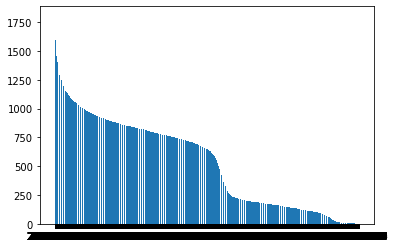

In [34]:
draw_from_dict(result_data_date,num_date)

We decide number of each day news <= 20

In [37]:
dates = []
for key,value in result_data_date.items():
  if value <=20:
    dates.append(key)
# len(sorted_ticker)
len(dates)

346

In [38]:
tmpData = {}
total = data['date'].nunique()
for i in tqdm(data['date'].unique()):
    headline = data.loc[(data['date'] == i)]['title']
    if len(headline)>=20:
      tmpData[i] = headline[:20].tolist()
    else:
      tmpData[i] = headline.tolist()


100%|██████████| 4423/4423 [14:31<00:00,  5.08it/s]


In [40]:
# list_date_filtered = data['date'].values.tolist()
# result_data_date_filtered = dict(zip(*np.unique(tmpData, return_counts=True)))

In [ ]:
# draw_from_dict(result_data_date,num_date)

In [ ]:
# df = pd.DataFrame(data=None)
# for key,value in filtered_by_date.items():
#   df.iloc[key] = value
# filtered_by_date

# **Add label**

In [41]:
ONE_DAY = datetime.timedelta(days=1)
HOLIDAYS_US = holidays.US()
def next_business_day(dateString):
    datetimeObj = datetime.datetime.strptime(dateString, '%Y-%m-%d')
    next_day = datetimeObj + ONE_DAY
    while next_day.weekday() in holidays.WEEKEND or next_day in HOLIDAYS_US:
        next_day += ONE_DAY
    return next_day

def prev_business_day(dateString):
    datetimeObj = datetime.datetime.strptime(dateString, '%Y-%m-%d')
    prev_day = datetimeObj - ONE_DAY
    while prev_day.weekday() in holidays.WEEKEND or prev_day in HOLIDAYS_US:
        prev_day -= ONE_DAY
    return prev_day

In [42]:
tickerSymbol = "SPY"
ticker = yf.Ticker(tickerSymbol)
hist = ticker.history(period="max")


In [43]:
hist

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1993-01-29,25.818120,25.818120,25.689672,25.799770,1003200,0.0,0
1993-02-01,25.818125,25.983273,25.818125,25.983273,480500,0.0,0
1993-02-02,25.964916,26.056665,25.909866,26.038315,201300,0.0,0
1993-02-03,26.075019,26.331916,26.056669,26.313566,529400,0.0,0
1993-02-04,26.405305,26.478704,26.111709,26.423655,531500,0.0,0
...,...,...,...,...,...,...,...
2021-07-29,439.820007,441.799988,439.809998,440.649994,47435300,0.0,0
2021-07-30,437.910004,440.059998,437.769989,438.510010,68890600,0.0,0
2021-08-02,440.339996,440.929993,437.209991,437.589996,58783300,0.0,0


In [54]:
data_new = pd.DataFrame(columns =['Text','Close','Return','Label'], data=None)
filtered_by_date = tmpData
idx = 0
for i in tqdm(filtered_by_date):
  start = i
  prev = prev_business_day(start).strftime("%Y-%m-%d")
  try:
    prevDay = hist.loc[prev]
    startDay = hist.loc[start]
    close = startDay['Close']
    prev_close = prevDay['Close']
    log_return = np.log(close) - np.log(prev_close)
    # label = startDay['Close'] - prevDay['Close']
    # print(close)
    # data_new.loc[i,'Date'] = key
    

    for txt in tmpData[i]:
      idx += 1
      data_new.loc[idx,'Text'] = txt
      # data_new.loc[key,'Text'] = txt
      # data_new.loc[i,'Label'] = label
      data_new.loc[idx,'Close'] = close
      data_new.loc[idx,'Return'] = log_return

    # data_new.loc[i,'Close'] = close
  except:
    pass

100%|██████████| 4423/4423 [03:11<00:00, 23.09it/s]


## Two labels

In [55]:
data_with_2label = data_new

In [56]:
data_with_2label

,Text,Close,Return,Label
1,German Automakers Are Charged Up and Ready to ...,371.444,0.00506791,NaN
2,Siblings Are Killed in I-95 Crash in Florida a...,371.444,0.00506791,NaN
3,"Yup, People Are Going to Parties on New Year’s...",371.444,0.00506791,NaN
4,11 Things Our Critics Are Looking Forward to i...,371.444,0.00506791,NaN
5,Becky Hammon Becomes First Woman to Serve as H...,371.444,0.00506791,NaN
...,...,...,...,...
31614,Adapting Listerine to a Global Market,174.208,-0.00585831,NaN
31615,Letter from Israel’s Unit 8200,174.208,-0.00585831,NaN
31616,Prizes Without Passion,174.208,-0.00585831,NaN
31617,N.F.L. Rocked Again as Adrian Peterson Faces a...,174.208,-0.00585831,NaN


In [63]:
data_with_2label['Label'] = data_with_2label['Return'].map(lambda x:1 if x>=0 else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


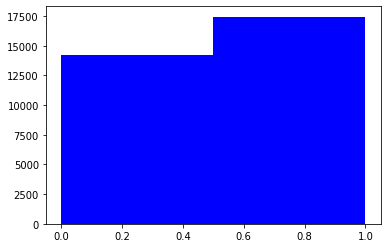

In [64]:
fig = plt.figure()
x = data_with_2label['Label']
ax = fig.add_subplot(111)
numBins = 2
ax.hist(x,numBins,color='blue')
# plt.grid(true)#
# plt.title(u'weight')
plt.show()

{'boxes': [<matplotlib.lines.Line2D at 0x7f8609421b50>],
 'caps': [<matplotlib.lines.Line2D at 0x7f8609425890>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f86094148d0>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f8609414390>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f8609421590>,
  <matplotlib.lines.Line2D at 0x7f8609425350>]}

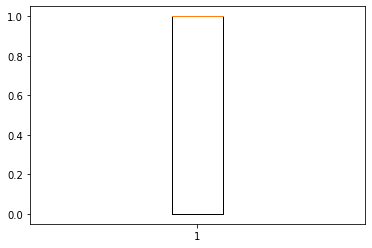

In [65]:
plt.boxplot(data_with_2label['Label'])

## Three labels

In [57]:
data_with_3label = data_new

In [58]:
return_list = data_with_3label['Return']

In [59]:
return_list_percentile = np.percentile(return_list, (39, 50, 62), interpolation='midpoint')
return_list_percentile

array([-0.0008517247410919637, 0.0005904717608444798,
       0.0024686714059454218], dtype=object)

In [60]:
data_with_3label['Label'] = data_with_3label['Return'].map(lambda x:1 if x>return_list_percentile[2] else (-1 if x<return_list_percentile[0] else 0))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


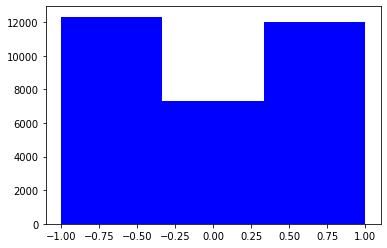

In [61]:
fig = plt.figure()
x = data_with_3label['Label']
ax = fig.add_subplot(111)
numBins = 3
ax.hist(x,numBins,color='blue')
# plt.grid(true)#
# plt.title(u'weight')
plt.show()

{'boxes': [<matplotlib.lines.Line2D at 0x7f86121a2310>],
 'caps': [<matplotlib.lines.Line2D at 0x7f86121a3350>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f86121a8390>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f86121a3e10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f86121a2890>,
  <matplotlib.lines.Line2D at 0x7f86121a2dd0>]}

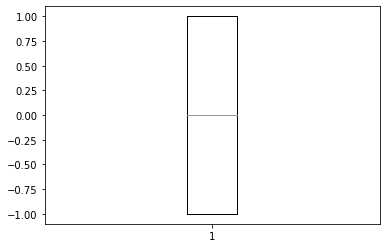

In [62]:
plt.boxplot(data_with_3label['Label'])

In [66]:
data_with_2label.to_csv(path_or_buf=r'data_2_label.csv')
print('data saved')

data saved


In [67]:
data_with_3label.to_csv(path_or_buf=r'data_3_label.csv')
print('data saved')

data saved


In [ ]:
data_new

,Text,Label
2020-06-11,"UBS Maintains Neutral on McDonald's, Raises Pr...",negative
2020-06-10,"Hearing Vertical Group Out Positive On Amazon,...",negative
2020-06-09,Macy's Raises $4.5B In Funding To Navigate Pos...,positive
2020-06-08,NXP Semiconductors shares are trading higher a...,positive
2020-06-05,Shares of several airline companies are tradin...,positive
...,...,...
2008-10-10,GLOBAL MARKETS Selling frenzy persists as conf...,positive
2008-10-09,GLOBAL MARKETS Stocks falter safe havens fall...,negative
2008-10-07,GLOBAL MARKETS U S stocks slide gold rises o...,negative
2008-10-06,GLOBAL MARKETS Credit crisis fears spark globa...,negative


In [ ]:
data_new.to_csv(path_or_buf=r'yingwen_pretrained_demo.csv')
print('data saved')

data saved


In [ ]:

data_new = pd.read_csv(r'yingwen_pretrained_demo.csv')

In [ ]:
data_new.describe()

,Unnamed: 0,Text,Label
count,2917,2917,2917
unique,2917,2917,3
top,2016-01-04,Swedish c bank seen cutting key rate 50 bps in...,positive
freq,1,1,1588
